# Тестирование на реальных данных

В этом коде приведен пример применения портфельной теории Марковица и построение эффективной границы на реальных данных.

Использованы 4 акции, торгуемые на фондовом рынке РФ:
- Сбербанк (SBER)
- Газпром (GAZP)
- Лукойл (LKOH)
- ГМК Норильский никель (GMKN)

In [1]:
import pandas as pd
import numpy as np
import scipy.optimize as sco
import matplotlib.pyplot as plt
import matplotlib.cm as cm

%matplotlib inline
# Для отрисовки сетки за графиком
plt.rc('axes', axisbelow=True)

In [596]:
price = pd.DataFrame()
stocks = ['GAZP', 'LKOH', 'GMKN', 'SBER']
for symbol in stocks:
    price[symbol] = pd.read_csv('./csv/'+symbol+'.csv', parse_dates=['Date'], index_col=0)['Close']['2006-09-01':'2018-10-01']

In [597]:
price.shape

(3023, 4)

In [598]:
price.head()

,GAZP,LKOH,GMKN,SBER
Date,,,,
2006-09-01,309.23,2245.08,3543.65,56.25555
2006-09-04,311.30,2286.53,3593.55,58.27574
2006-09-05,310.65,2300.65,3640.66,59.95937
2006-09-06,301.95,2226.59,3573.62,59.23431
2006-09-07,294.98,2173.78,3394.92,57.57095


In [599]:
# Удаление NaN строк
price.dropna(inplace=True)

Ниже приведены функции для получения портфеля с наибольшим коэффициентом Шарпа.
Поскольку в Scipy's optimize function отсутствует «максимизация» минимизируем "neg_sharpe_ratio", вычисляющий отрицательный коэффициент Шарпа. 

Поскольку доли акций в портфеле суммарно не должны превышать 1 то:
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

Поскольку нельзя задать отрицательное распределение ровно, как и превысить 100 % показатель, границы задают долям акций интервал от 0 до 1

In [600]:
def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights ) * num_periods_annually
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(num_periods_annually)
    return std, returns

In [601]:
def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    p_var, p_ret = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
    return -(p_ret - risk_free_rate) / p_var

In [602]:
def max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))
    
    result = sco.minimize(neg_sharpe_ratio, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result

Также можно определить оптимизирующую функцию для расчета минимального показателя риска. На этот раз минимизируем целевую функцию – риск (min_variance), используя разные показатели долей акций. "Constraints" и "bounds" такие же, как и выше.

In [603]:
def portfolio_volatility(weights, mean_returns, cov_matrix):
    return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[0]

In [604]:
def min_variance(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))

    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args,
                          method='SLSQP', bounds=bounds, constraints=constraints)

    return result

Ниже приведены функции для вычисления эффективной границы. Первая - "efficient_return" вычисляет самый эффективный портфель для заданного риска, а вторая - "efficient_frontier" принимает диапазон целевых доходностей и вычисляет эффективный портфель для каждой из них.

In [605]:
def efficient_return(mean_returns, cov_matrix, target):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)

    def portfolio_return(weights):
        return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[1]

    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_return(x) - target},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0,1) for asset in range(num_assets))
    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args,
                          method='SLSQP', bounds=bounds, constraints=constraints)
    return result

In [606]:
def efficient_frontier(mean_returns, cov_matrix, returns_range):
    efficients = []
    for ret in returns_range:
        efficients.append(efficient_return(mean_returns, cov_matrix, ret))
    return efficients

Построим портфель с максимальным коэффициентом Шарпа и минимальным риском, а также отразим все случайно сгенерированные портфели.Приведенная ниже функция также строит границу эффективности.

In [607]:
def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    results = np.zeros((3,num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        weights = np.random.random(len(stocks))
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return results, weights_record

---

In [608]:
num_portfolios = 10000 # Кол-во расчитываемых портфелей (итераций)
risk_free_rate = 0.00 # Безрисковая процентная ставка
num_periods_annually = 1 # Количество операционных дней в году

In [609]:
returns = price.pct_change()
mean_returns = returns.mean()
cov_matrix = returns.cov()

Оптимизируем. Ищем портфель с максимальным коэффициентом шарпа (max_sharpe) и минимальным риском (min_vol)

In [610]:
max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
min_vol = min_variance(mean_returns, cov_matrix)

In [611]:
sdp, rp = portfolio_annualised_performance(max_sharpe['x'], mean_returns, cov_matrix)
max_sharpe_allocation = pd.DataFrame(max_sharpe.x.copy(),index=price.columns,columns=['allocation'])
max_sharpe_allocation.allocation = [round(i*100,2) for i in max_sharpe_allocation.allocation]
max_sharpe_allocation = max_sharpe_allocation.T

In [612]:
sdp_min, rp_min = portfolio_annualised_performance(min_vol['x'], mean_returns, cov_matrix)
min_vol_allocation = pd.DataFrame(min_vol.x.copy(),index=price.columns,columns=['allocation'])
min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
min_vol_allocation = min_vol_allocation.T

Находим (оптимизируем) эффективную границу портфелей

In [613]:
target = np.linspace(rp_min, 0.00081, 20)
efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)

Преобразуем оптимизированные параметры для нормального отображения при использовании print

Генерируем (метод Монте Карло) num_portfolios случайных портфелей для отрисовки их на графике

In [614]:
results, _ = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.001
Annualised Volatility: 0.024
Sharpe Ratio: 0.032
            GAZP  LKOH   GMKN   SBER
allocation   0.0   0.0  49.23  50.77
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.0
Annualised Volatility: 0.021
Sharpe Ratio: 0.021
             GAZP   LKOH   GMKN  SBER
allocation  31.16  39.63  29.21   0.0


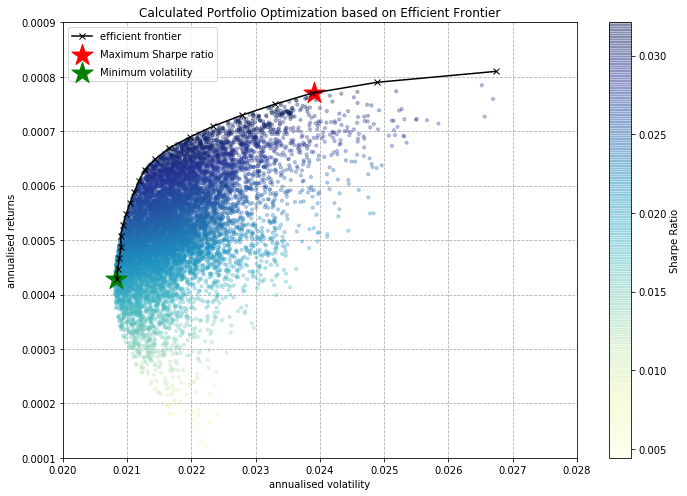

In [615]:
print("-"*80)
print("Распределение долей акций в портфеле с максимальным коэффициентом Шарпа:\n")
print("Годовая доходность:", round(rp,3))
print("Годовой риск:", round(sdp,3))
print("Коэффициент Шарпа:", round((rp - risk_free_rate)/sdp, 3))
print(max_sharpe_allocation)
print("-"*80)
print("Распределение долей акций в портфеле с наименьшим показателем риска:\n")
print("Годовая доходность:", round(rp_min,3))
print("Годовой риск:", round(sdp_min,3))
print("Коэффициент Шарпа:", round((rp_min - risk_free_rate)/sdp_min, 3))
print(min_vol_allocation)

plt.figure(figsize=(10, 7))
plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
plt.colorbar(label='Коэффициент Шарпа:')
plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Максимальный коэф-т Шарпа')
plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Минимальный риск')

plt.plot([p['fun'] for p in efficient_portfolios], target, 'k-x', label='граница эффективности')
plt.title('Оптимизация портфеля на основе построения эффективной границы')
plt.xlabel('Риск(стандартное отклонение)')
plt.ylabel('Доходность')
plt.grid(True, linestyle='--')
plt.legend(labelspacing=0.8)

plt.xlim(0.02, 0.028)
plt.ylim(0.0001, 0.0009)

plt.tight_layout();

In [616]:
ind = np.arange(price.columns.size)
width = 0.35

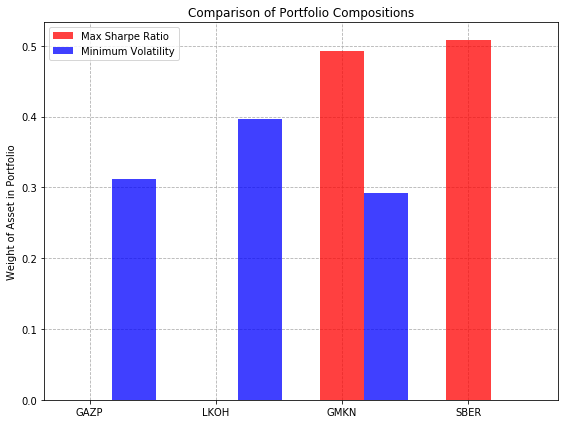

In [617]:
plt.figure(figsize=(8,6))
plt.bar(ind, max_sharpe['x'], width, color='r', alpha=0.75)
plt.bar(ind + width, min_vol['x'], width, color='b', alpha=0.75)

plt.xticks(ind, stocks)
plt.ylabel('Распределение акций в портфеле')
plt.title('Cравнение сотавов портфелей')
plt.legend(('Максимальный коэф-т Шарпа', 'Минимальный Риск'))
plt.grid(b=True, linestyle='--')

plt.tight_layout()

In [618]:
max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
sdp, rp = portfolio_annualised_performance(max_sharpe['x'], mean_returns, cov_matrix)
max_sharpe_allocation = pd.DataFrame(max_sharpe.x.copy(),index=price.columns,columns=['allocation'])
max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
max_sharpe_allocation = max_sharpe_allocation.T

min_vol = min_variance(mean_returns, cov_matrix)
sdp_min, rp_min = portfolio_annualised_performance(min_vol['x'], mean_returns, cov_matrix)
min_vol_allocation = pd.DataFrame(min_vol.x.copy(),index=price.columns,columns=['allocation'])
min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
min_vol_allocation = min_vol_allocation.T

an_vol = np.std(returns) * np.sqrt(num_periods_annually)
an_rt = mean_returns * num_periods_annually

In [619]:
target = np.linspace(rp_min, 0.00081, 20)
efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.0
Annualised Volatility: 0.02
Sharpe Ratio: 0.032
            GAZP  LKOH   GMKN   SBER
allocation   0.0   0.0  49.23  50.77
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.0
Annualised Volatility: 0.02
Sharpe Ratio: 0.021
             GAZP   LKOH   GMKN  SBER
allocation  31.16  39.63  29.21   0.0
--------------------------------------------------------------------------------
Individual Stock Returns and Volatility

GAZP : annuaised return 0.0 , annualised volatility: 0.02
LKOH : annuaised return 0.0 , annualised volatility: 0.02
GMKN : annuaised return 0.0 , annualised volatility: 0.03
SBER : annuaised return 0.0 , annualised volatility: 0.03
--------------------------------------------------------------------------------


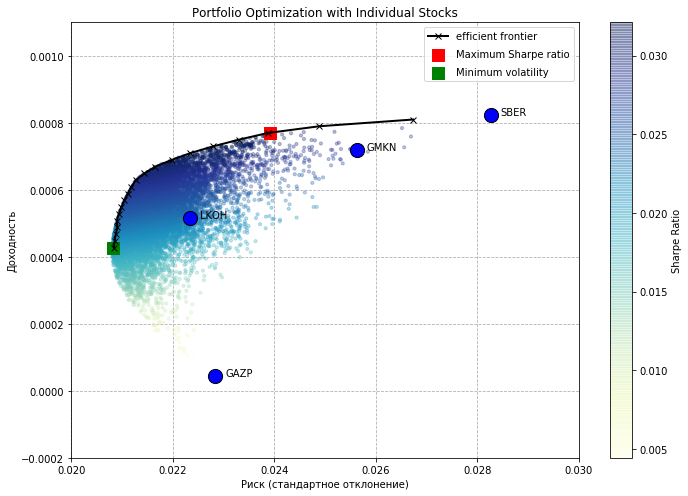

In [620]:
print("-"*80)
print("Распределение долей акций в портфеле с максимальным коэффициентом Шарпа\n")
print("Годовая доходность:", round(rp,2))
print("Годовой риск:", round(sdp,2))
print("Коэффициент Шарпа:", round((rp - risk_free_rate)/sdp, 3))
print(max_sharpe_allocation)
print("-"*80)
print("Распределение долей акций в портфеле с наименьшим показателем риска:\n")
print("Годовая доходность:", round(rp_min,2))
print("Годовой риск:", round(sdp_min,2))
print("Коэффициент Шарпа:", round((rp_min - risk_free_rate)/sdp_min, 3))
print(min_vol_allocation)
print("-"*80)

print("Показатели доходности и риска каждой отдельной акции:\n")
for i, txt in enumerate(price.columns):
    print(txt,":","годовая доходность:",round(an_rt[i],2),", годовой риск:",round(an_vol[i],2))
print("-"*80)

plt.subplots(figsize=(10, 7))

for i, txt in enumerate(price.columns):
    plt.annotate(txt, (an_vol[i], an_rt[i]), xytext=(10,0), textcoords='offset points')

# coolwarm RdBu YlGnBu
plt.scatter(results[0,:],results[1,:],c=results[2,:], cmap=cm.YlGnBu, marker='o', s=10, alpha=0.3)
plt.colorbar(label='Коэффициент Шарпа')

plt.scatter(sdp, rp, marker='s',color='r',s=150, label='Максимальный коэф-т Шарпа')
plt.scatter(sdp_min, rp_min,marker='s',color='g',s=150, label='Минимальный риск')

plt.scatter(an_vol, an_rt, marker='o', s=200, c='blue', edgecolors='black')

plt.plot([p['fun'] for p in efficient_portfolios], target, 'k-x', linewidth=2, label='граница эффективности')
plt.title('Оптимизация портфеля и показатели отдельный акций')
plt.xlabel('Риск (стандартное отклонение)')
plt.ylabel('Доходность')
plt.legend(labelspacing=0.8)
plt.grid(True, linestyle='--')

plt.xlim(0.02, 0.03)
plt.ylim(-0.0002, 0.0011)

plt.tight_layout();

Наименьший показатель риска у акциии LKOH, но принцип диверсификации позволяет как повысить уровень доходности джля заданного риска так и снизить его за счет рационального подхода к формированию портфеля, а не приобретения отдельной акции.